# PCA PLAYGROUND

In [1]:
import numpy as np
import pandas as pd
import plotly_express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from plotly.express.colors import sample_colorscale
from sklearn.preprocessing import minmax_scale
from sklearn import preprocessing
from pca import pca


df_annot_final = pd.read_csv(
    '/Users/Paul/Paul/Desktop/My_projects/Bioacoustics/Maputo_Dash/datasets/tables/annot_new2.csv')

In [2]:
df_annot_final['species'] = df_annot_final['species'].replace('spelndens','splendens')

# Select PCA features

In [3]:
GENERIC_FEATURES = ['min_f', 'max_f', 'centroid_f',
                    'duration_t', 'bandwidth_f', 'area_tf']

SHAPE_FEATURES = ['shp_002', 'shp_003', 'shp_004', 'shp_005', 'shp_006', 'shp_007',
                  'shp_008', 'shp_009', 'shp_010', 'shp_011', 'shp_012', 'shp_013',
                  'shp_014', 'shp_015', 'shp_016', 'shp_017', 'shp_018', 'shp_019',
                  'shp_020', 'shp_021', 'shp_022', 'shp_023', 'shp_024', 'shp_025',
                  'shp_026', 'shp_027', 'shp_028', 'shp_029', 'shp_030', 'shp_031',
                  'shp_032', 'shp_033', 'shp_034', 'shp_035', 'shp_036', 'shp_037',
                  'shp_038', 'shp_039', 'shp_040', 'shp_041', 'shp_042', 'shp_043',
                  'shp_044', 'shp_045', 'shp_046', 'shp_047', 'shp_048']


SPECTRAL_FEATURES = ['MEANf', 'VARf', 'SKEWf', 'KURTf', 'NBPEAKS', 'LEQf',
                     'ENRf', 'BGNf', 'SNRf', 'Hf', 'EAS', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'ACI',
                     'NDSI', 'ROU']

TEMPORAL_FEATURES = ['ZCR', 'MEANt', 'VARt',
                     'SKEWt', 'KURTt', 'Ht']


# Compute PCA

In [4]:
df = df_annot_final.copy()
df = df.reset_index()
color = 'biotope'
features = GENERIC_FEATURES

df = df.dropna(how='all')
# Scale Features
data_scaled = pd.DataFrame(preprocessing.scale(
    df[features]), columns=df[features].columns)
# PCA
pca = PCA(n_components=3)
components = pca.fit_transform(data_scaled)
total_var = pca.explained_variance_ratio_.sum() * 100

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Dump components relations with features:
weights = (pd.DataFrame(pca.components_,
            columns=data_scaled.columns, index=[f'PC-{i+1}' for i in range(3)]))
weights = weights.reset_index()

# figures-----------------------
labels = {
    str(i): f"PC {i+1} ({var1:.1f}%) - EV = {var2:.1f}" for i, (var1, var2) in enumerate(zip(pca.explained_variance_ratio_ * 100, pca.explained_variance_))
}

colors_ = np.linspace(0, 1, len(df[color].unique()))
discrete_colors = sample_colorscale('Rainbow', minmax_scale(colors_))

In [5]:
ROI_PC_coordinates = pd.DataFrame(components)
ROI_PC_coordinates.columns = ['PC1', 'PC2','PC3']
ROI_coordinates = pd.concat([df[['species', 'genus', 'family', 'order','biotope', 'sound_id']],ROI_PC_coordinates],axis=1)


# Compute ellipses and overlap

In [6]:
ROI_coordinates.head(2)

,species,genus,family,order,biotope,sound_id,PC1,PC2,PC3
0,africanoides,Calendulauda,Alaudidae,Passeriformes,Grasslands,449420,2.801196,1.412692,-0.897027
1,africanoides,Calendulauda,Alaudidae,Passeriformes,Grasslands,449420,3.214773,2.153596,-0.401168


In [13]:
ROI_coordinates[ROI_coordinates['biotope']=='Grasslands'].loc[:,['PC1','PC2']]

,PC1,PC2
0,2.801196,1.412692
1,3.214773,2.153596
2,1.271617,1.391316
3,3.760102,2.606550
4,3.713450,3.906413
...,...,...
3366,-1.143976,0.161063
3367,-1.548343,0.120652
3368,-1.249593,0.446849
3369,-1.337027,0.623907


In [66]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


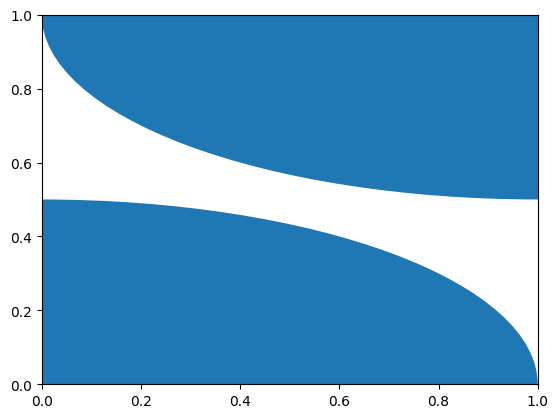

In [80]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.path import Path
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots()

# Create three ellipses
e1 = Ellipse(xy=(0,0), width=2, height=1)
e2 = Ellipse(xy=(1,1), width=2, height=1)
e3 = Ellipse(xy=(1,-1), width=2, height=1)

# Add the ellipses to the axis
ax.add_patch(e1)
ax.add_patch(e2)
ax.add_patch(e3)

# Create a Path object for each ellipse
p1 = Path(e1.get_verts())
p2 = Path(e2.get_verts())
p3 = Path(e3.get_verts())

# Compute the overlap ratio of each pair of ellipses
overlap_12 = p1.intersects_path(p2, filled=True)
overlap_13 = p1.intersects_path(p3, filled=True)
overlap_23 = p2.intersects_path(p3, filled=True)

# Clip each pair of Path objects to the bounding box of the intersection
if overlap_12:
    p1, p2 = p1.clip_to_bbox(p1.get_extents()), p2.clip_to_bbox(p1.get_extents())
if overlap_13:
    p1, p3 = p1.clip_to_bbox(p1.get_extents()), p3.clip_to_bbox(p1.get_extents())
if overlap_23:
    p2, p3 = p2.clip_to_bbox(p2.get_extents()), p3.clip_to_bbox(p2.get_extents())

# Create a regular grid of points
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
points = np.c_[xx.ravel(), yy.ravel()]

# Compute the area of each Path object
area_1 = np.count_nonzero(p1.contains_points(points))
area_2 = np.count_nonzero(p2.contains_points(points))
area_3 = np.count_nonzero(p3.contains_points(points))

# Compute the overlap ratio of each pair of


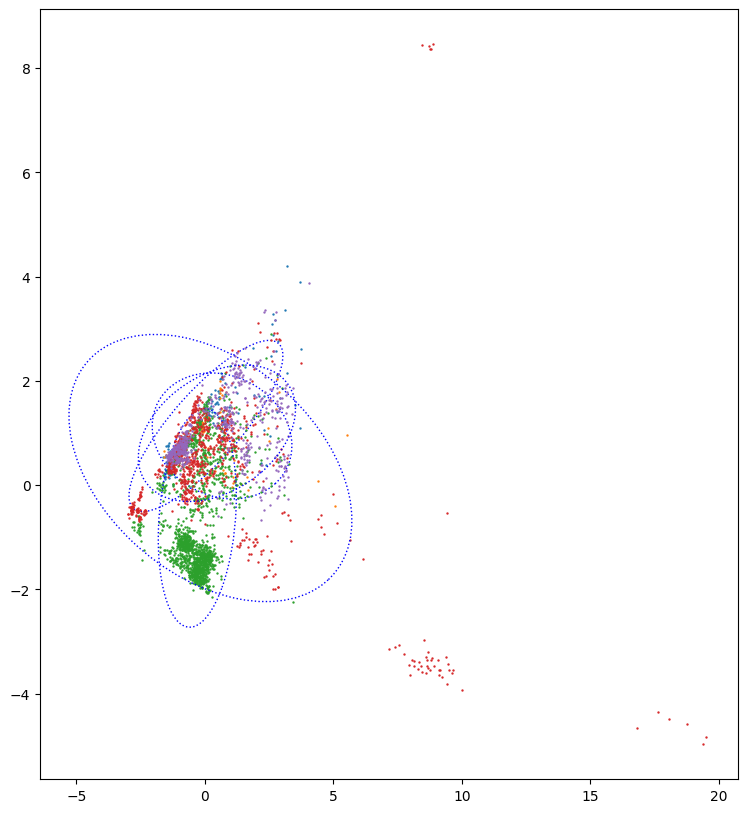

In [90]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

fig, axs = plt.subplots(figsize=(9, 10))

def get_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ellipse



df_data = ROI_coordinates.copy()
# Add ellipses around the points in each group
biotope_ellipse_dict = {}
for group in df_data['biotope'].unique():
    subset = df_data[df_data['biotope'] == group]
    x = subset["PC1"]
    y = subset["PC2"]
    axs.scatter(x, y, s=0.5)
    confidence_ellipse(x, y, axs, n_std=2,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':')
    ellipse = get_ellipse(x, y, axs, n_std=2,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':')
    biotope_ellipse_dict[group]=ellipse
    
plt.show()




In [91]:
my_dict['Grasslands']

In [92]:
e1 = my_dict['Grasslands']
e2 = my_dict['Wetlands']
e3 = my_dict['Grasslands']

# Create a Path object for each ellipse
p1 = Path(e1.get_verts())
p2 = Path(e2.get_verts())
p3 = Path(e3.get_verts())

# Compute the overlap ratio of each pair of ellipses
overlap_12 = p1.intersects_path(p2, filled=True)
overlap_13 = p1.intersects_path(p3, filled=True)
overlap_23 = p2.intersects_path(p3, filled=True)

# Clip each pair of Path objects to the bounding box of the intersection
if overlap_12:
    p1, p2 = p1.clip_to_bbox(p1.get_extents()), p2.clip_to_bbox(p1.get_extents())
if overlap_13:
    p1, p3 = p1.clip_to_bbox(p1.get_extents()), p3.clip_to_bbox(p1.get_extents())
if overlap_23:
    p2, p3 = p2.clip_to_bbox(p2.get_extents()), p3.clip_to_bbox(p2.get_extents())

# Create a regular grid of points
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
points = np.c_[xx.ravel(), yy.ravel()]

# Compute the area of each Path object
area_1 = np.count_nonzero(p1.contains_points(points))
area_2 = np.count_nonzero(p2.contains_points(points))
area_3 = np.count_nonzero(p3.contains_points(points))

# Compute the overlap ratio of each pair of


In [95]:
area_3

0

# Get barycenters of various groups

In [ ]:
ROI_coordinates[ROI_coordinates.genus == 'Corvus']

## Get barycenter for Biotopes, and then for species and families inside of that biotope

In [ ]:
df_biotope_barycenter = pd.DataFrame()
barycenters_biotope_family = pd.DataFrame()
barycenters_biotope_species = pd.DataFrame()
results=pd.DataFrame()
results2=pd.DataFrame()
i=0
j=0

for b in ROI_coordinates['biotope'].unique():
    dff = ROI_coordinates[ROI_coordinates['biotope']==b]
    df_biotope_barycenter.loc[i,'biotope'] = str(b)
    df_biotope_barycenter.loc[i,'PC1_barycenter']=dff['PC1'].sum()/dff['PC1'].count()
    df_biotope_barycenter.loc[i,'PC2_barycenter']=dff['PC2'].mean()
    df_biotope_barycenter.loc[i,'PC3_barycenter']=dff['PC3'].mean()
    i+=1
    for f in dff['family'].unique():
        dff2 = dff[dff['family']==f]
        
        results.loc[j,'biotope']=str(b)
        results.loc[j,'family']=str(f)
        results.loc[j,'PC1_barycenter']=dff2['PC1'].mean()
        results.loc[j,'PC2_barycenter']=dff2['PC2'].mean()
        results.loc[j,'PC3_barycenter']=dff2['PC3'].mean()
        j+=1
    barycenters_biotope_family = pd.concat([barycenters_biotope_family,results], axis=0).drop_duplicates()
    
    for s in dff['species'].unique():
        dff3 = dff[dff['species']==s]
        
        results2.loc[j,'biotope']=str(b)
        results2.loc[j,'species']=str(s)
        results2.loc[j,'PC1_barycenter']=dff3['PC1'].mean()
        results2.loc[j,'PC2_barycenter']=dff3['PC2'].mean()
        results2.loc[j,'PC3_barycenter']=dff3['PC3'].mean()
        j+=1
    barycenters_biotope_species = pd.concat([barycenters_biotope_species,results2], axis=0).drop_duplicates()


In [ ]:
df_biotope_barycenter

In [ ]:
barycenters_biotope_family

In [ ]:
barycenters_biotope_species

## write to csv

In [ ]:
barycenters_biotope_family.to_csv('biotope_family_centroids.csv')
barycenters_biotope_species.to_csv('biotope_species_centroids.csv')
df_biotope_barycenter.to_csv('biotope_centroids.csv')


# PLOT THE PCA - SHOW CENTROIDS - COMPUTE DISTANCES

In [ ]:
import plotly.graph_objects as go
import plotly_express as px
import itertools


# standard 2D PC with loadings

In [ ]:
figtest = go.Figure()
figtest.add_shape(type='circle',x0=-1, x1=1, y0=-1,y1=1)

for i, feature in enumerate(features):
    figtest.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    figtest.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
figtest.update_layout(yaxis_range=[-1,1])
figtest.update_layout(xaxis_range=[-1,1], height=400, width = 400, title ='PCA Correlation circle' , xaxis_title='PC1', yaxis_title='PC2')

figtest.show()


In [ ]:
fig = px.scatter(ROI_coordinates,x='PC1',y='PC2',color='biotope', height = 1000)



for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

# all families

In [ ]:
px.scatter(ROI_coordinates, x='PC1',y='PC2',color='biotope',facet_col='family',facet_col_wrap=4, height=2000)

# all biotopes

In [61]:

colors_ = np.linspace(0, 1, len(ROI_coordinates['family'].unique()))
discrete_colors = sample_colorscale('turbo', minmax_scale(colors_))

px.scatter(ROI_coordinates, x='PC1',y='PC2',facet_col='biotope',color='family',
        color_discrete_sequence=discrete_colors, height=750)

In [ ]:
barycenters_biotope_family

# All biotopes and families + centroids

In [ ]:
data = []

colors_ = np.linspace(0, 1, len(ROI_coordinates['family'].unique()))
discrete_colors = sample_colorscale('turbo', minmax_scale(colors_))
col_pal_iterator = itertools.cycle(discrete_colors) 

for b in ROI_coordinates['biotope'].unique():
    df_biotope_filter = ROI_coordinates[ROI_coordinates['biotope'] == b]

    for f in df_biotope_filter['family'].unique():
        new_colour = next(col_pal_iterator)
        df_biotope_and_family_filter = df_biotope_filter[df_biotope_filter['family'] == f]
        trace = go.Scatter(x=df_biotope_and_family_filter['PC1'], 
                            y=df_biotope_and_family_filter['PC2'],
                            mode='markers',
                            marker=dict(size=4, color=new_colour),
                            name=f)
        data.append(trace)    
        
        df_group_BARYCENTER = barycenters_biotope_family[barycenters_biotope_family['family'] == f]
        
        trace2 = go.Scatter(x=df_group_BARYCENTER['PC1_barycenter'], 
                            y=df_group_BARYCENTER['PC2_barycenter'],
                            mode='markers',
                            marker=dict(size=10,line=dict(width=2,color='DarkSlateGrey'), color=new_colour),
                            name=f+'_'+b+'_BARYCENTER')
        data.append(trace2)
    
# Layout of the plot
layout = go.Layout(title='PCA - All biotopes with centroids', height=1000)
fig = go.Figure(data=data, layout=layout)

fig.show()

# Subplots by biotope with centroids

In [ ]:
from plotly.subplots import make_subplots

colors_ = np.linspace(0, 1, len(ROI_coordinates['family'].unique()))
discrete_colors = sample_colorscale('turbo', minmax_scale(colors_))
col_pal_iterator = itertools.cycle(discrete_colors) 
row=0
fig = make_subplots(rows=5, cols=1,subplot_titles=list(ROI_coordinates['biotope'].unique()),shared_xaxes=True)

for b in ROI_coordinates['biotope'].unique():
    row+=1
    df_biotope_filter = ROI_coordinates[ROI_coordinates['biotope'] == b]
    df_barycenters_biotope_filter = barycenters_biotope_family[barycenters_biotope_family['biotope'] == b]
    data = []   
    for f in df_biotope_filter['family'].unique():
        new_colour = next(col_pal_iterator)
        df_biotope_and_family_filter = df_biotope_filter[df_biotope_filter['family'] == f]
        
        trace = go.Scatter(x=df_biotope_and_family_filter['PC1'], 
                            y=df_biotope_and_family_filter['PC2'],
                            mode='markers',
                            marker=dict(size=4, color=new_colour),
                            name=f,legendgroup=str(row))
        data.append(trace)    
        
        df_group_BARYCENTER = df_barycenters_biotope_filter[df_barycenters_biotope_filter['family'] == f]
        
        
        trace2 = go.Scatter(x=df_group_BARYCENTER['PC1_barycenter'], 
                            y=df_group_BARYCENTER['PC2_barycenter'],
                            mode='markers',
                            marker=dict(size=10,line=dict(width=2,color='DarkSlateGrey'), color=new_colour),legendgroup=str(row),
                            name=f+'_'+b+'_BARYCENTER')
        data.append(trace2)
        fig.add_trace(trace, col=1,row=row)
        fig.add_trace(trace2, col=1,row=row)

fig.update_layout(height=1600, width=1000, title_text="PCA of all biotopes with centroids and family division",legend_tracegroupgap=180)

# Layout of the plot

# fig = go.Figure(data=data, layout=layout)

fig.show()


In [ ]:
weights

In [ ]:
df_annot_final.sound_id.nunique()

In [ ]:
fig = go.Figure(go.Indicator(
    mode = "number+delta",
    value = 400,
    number = {'prefix': "$"},
    delta = {'position': "top", 'reference': 320},
    domain = {'x': [0, 1], 'y': [0, 1]}))

fig.update_layout(paper_bgcolor = "lightgray")

fig.show()

In [ ]:
data = []

for group in df_biotope_barycenter['biotope']:
    df_group = ROI_coordinates[ROI_coordinates['biotope'] == group]
    trace = go.Scatter(x=df_group['PC1'], 
                        y=df_group['PC2'],
                        mode='markers',
                        marker=dict(size=3, colorscale='rainbow'),
                        name=group)
    data.append(trace)
    
for group in df_biotope_barycenter['biotope']:
    df_group_BARYCENTER = df_biotope_barycenter[df_biotope_barycenter['biotope'] == group]
    trace2 = go.Scatter(x=df_group_BARYCENTER['PC1_barycenter'], 
                        y=df_group_BARYCENTER['PC2_barycenter'],
                        mode='markers',
                        marker=dict(size=10,line=dict(width=2,color='DarkSlateGrey'), colorscale='rainbow'),
                        name=group+'_BARYCENTER')
    data.append(trace2)
    
# Layout of the plot
layout = go.Layout(title='PCA - All biotopes with centroids', height=1000)
fig = go.Figure(data=data, layout=layout)

fig.show()

In [ ]:
barycenters_biotope_family

In [ ]:
barycenters_biotope_family['family'].unique()

In [ ]:
data = []

filtered_by_forest = ROI_coordinates[ROI_coordinates['biotope'] == 'Forest'].drop_duplicates()
barycenters_filtered_by_forest = barycenters_biotope_family[barycenters_biotope_family['biotope'] == 'Forest'].drop_duplicates()


for f in ROI_coordinates['family'].unique():
    new_colour = next(col_pal_iterator)
    df_group = filtered_by_forest[filtered_by_forest['family'] == f]
    trace = go.Scatter(x=df_group['PC1'], 
                        y=df_group['PC2'],
                        mode='markers',
                        marker=dict(size=3, color=new_colour),
                        name=f)
    
    df_group_BARYCENTER = barycenters_filtered_by_forest[barycenters_filtered_by_forest['family'] == f]
    trace2 = go.Scatter(x=df_group_BARYCENTER['PC1_barycenter'], 
                        y=df_group_BARYCENTER['PC2_barycenter'],
                        mode='markers',
                        marker=dict(size=8,color=new_colour,line=dict(width=2,color='DarkSlateGrey')),
                        name=f+'_BARYCENTER')
    data.append(trace)
    data.append(trace2)
    
    
# Layout of the plot
layout = go.Layout(title='PCA - Forest biotope - colored by family with centroids', height=1000)
fig = go.Figure(data=data, layout=layout)

fig.show()

In [ ]:
data = []

filtered_by_Woodlands = ROI_coordinates[ROI_coordinates['biotope'] == 'Woodlands'].drop_duplicates()
barycenters_filtered_by_Woodlands = barycenters_biotope_family[barycenters_biotope_family['biotope'] == 'Woodlands'].drop_duplicates()


for f in ROI_coordinates['family'].unique():
    new_colour = next(col_pal_iterator)
    df_group = filtered_by_Woodlands[filtered_by_Woodlands['family'] == f]
    trace = go.Scatter(x=df_group['PC1'], 
                        y=df_group['PC2'],
                        mode='markers',
                        marker=dict(size=3, color=new_colour),
                        name=f)
    
    df_group_BARYCENTER = barycenters_filtered_by_Woodlands[barycenters_filtered_by_Woodlands['family'] == f]
    trace2 = go.Scatter(x=df_group_BARYCENTER['PC1_barycenter'], 
                        y=df_group_BARYCENTER['PC2_barycenter'],
                        mode='markers',
                        marker=dict(size=8,color=new_colour,line=dict(width=2,color='DarkSlateGrey')),
                        name=f+'_BARYCENTER')
    data.append(trace)
    data.append(trace2)
    
    
# Layout of the plot
layout = go.Layout(title='PCA - Woodlands biotope - colored by family with centroids', height=1000)
fig = go.Figure(data=data, layout=layout)

fig.show()

In [ ]:
data = []

filtered_by_forest = ROI_coordinates[ROI_coordinates['biotope'] == 'Wetlands'].drop_duplicates()
barycenters_filtered_by_forest = barycenters_biotope_family[barycenters_biotope_family['biotope'] == 'Wetlands'].drop_duplicates()


for f in ROI_coordinates['family'].unique():
    new_colour = next(col_pal_iterator)
    df_group = filtered_by_forest[filtered_by_forest['family'] == f]
    trace = go.Scatter(x=df_group['PC1'], 
                        y=df_group['PC2'],
                        mode='markers',
                        marker=dict(size=3, color=new_colour),
                        name=f)
    
    df_group_BARYCENTER = barycenters_filtered_by_forest[barycenters_filtered_by_forest['family'] == f]
    trace2 = go.Scatter(x=df_group_BARYCENTER['PC1_barycenter'], 
                        y=df_group_BARYCENTER['PC2_barycenter'],
                        mode='markers',
                        marker=dict(size=8,color=new_colour,line=dict(width=2,color='DarkSlateGrey')),
                        name=f+'_BARYCENTER')
    data.append(trace)
    data.append(trace2)
    
    
# Layout of the plot
layout = go.Layout(title='PCA - Wetlands biotope - colored by family with centroids', height=1000)
fig = go.Figure(data=data, layout=layout)

fig.show()

In [ ]:
data = []

filtered_by_forest = ROI_coordinates[ROI_coordinates['biotope'] == 'Grasslands'].drop_duplicates()
barycenters_filtered_by_forest = barycenters_biotope_family[barycenters_biotope_family['biotope'] == 'Grasslands'].drop_duplicates()


for f in ROI_coordinates['family'].unique():
    new_colour = next(col_pal_iterator)
    df_group = filtered_by_forest[filtered_by_forest['family'] == f]
    trace = go.Scatter(x=df_group['PC1'], 
                        y=df_group['PC2'],
                        mode='markers',
                        marker=dict(size=3, color=new_colour),
                        name=f)
    
    df_group_BARYCENTER = barycenters_filtered_by_forest[barycenters_filtered_by_forest['family'] == f]
    trace2 = go.Scatter(x=df_group_BARYCENTER['PC1_barycenter'], 
                        y=df_group_BARYCENTER['PC2_barycenter'],
                        mode='markers',
                        marker=dict(size=8,color=new_colour,line=dict(width=2,color='DarkSlateGrey')),
                        name=f+'_BARYCENTER')
    data.append(trace)
    data.append(trace2)
    
    
# Layout of the plot
layout = go.Layout(title='PCA - Grasslands biotope - colored by family with centroids', height=1000)
fig = go.Figure(data=data, layout=layout)

fig.show()

In [ ]:
data = []

filtered_by_forest = ROI_coordinates[ROI_coordinates['biotope'] == 'Marshlands'].drop_duplicates()
barycenters_filtered_by_forest = barycenters_biotope_family[barycenters_biotope_family['biotope'] == 'Marshlands'].drop_duplicates()


for f in ROI_coordinates['family'].unique():
    new_colour = next(col_pal_iterator)
    df_group = filtered_by_forest[filtered_by_forest['family'] == f]
    trace = go.Scatter(x=df_group['PC1'], 
                        y=df_group['PC2'],
                        mode='markers',
                        marker=dict(size=3, color=new_colour),
                        name=f)
    
    df_group_BARYCENTER = barycenters_filtered_by_forest[barycenters_filtered_by_forest['family'] == f]
    trace2 = go.Scatter(x=df_group_BARYCENTER['PC1_barycenter'], 
                        y=df_group_BARYCENTER['PC2_barycenter'],
                        mode='markers',
                        marker=dict(size=8,color=new_colour,line=dict(width=2,color='DarkSlateGrey')),
                        name=f+'_BARYCENTER')
    data.append(trace)
    data.append(trace2)
    
    
# Layout of the plot
layout = go.Layout(title='PCA - Marshland biotope - colored by family with centroids', height=1000)
fig = go.Figure(data=data, layout=layout)

fig.show()

In [ ]:
scatter = go.Figure()

scatter.add_trace(go.Scatter(x=ROI_coordinates['PC1'],y=ROI_coordinates['PC2'],mode='markers'))
scatter.add_trace(go.Scatter(x=df_biotope_barycenter['PC1_barycenter'],y=df_biotope_barycenter['PC2_barycenter'],mode='markers',name='barycenters',
                              marker=dict(size=10)))
# scatter.data = (scatter.data[5],scatter.data[3])

# scatter.data = scatter.data[::-1]

In [ ]:
px.colors.qualitative.Plotly

In [ ]:
scatter = px.scatter(components, x=0,y=1,height=1000)


In [ ]:
scatter.show()

In [ ]:
for_glenn = pd.concat([df[['species', 'genus', 'family', 'order','biotope', 'sound_id']],pd.DataFrame(components)],axis=1)

In [ ]:
ROI_coordinates.to_csv('PC_results_glenn.csv')

In [ ]:
fig = px.scatter_matrix(
    components,
    height=1000,
    labels=labels,
    dimensions=range(dimensions),
    color=df[color],
    color_discrete_sequence=discrete_colors,
    title=f'Principal component analysis of ROIs ---Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)


In [ ]:
features_options='basic'
dimensions=2
color="species"

df = df_annot.copy()
df = df.reset_index()

if features_options == 'basic':
    features = GENERIC_FEATURES
if features_options == 'shapes':
    features = SHAPE_FEATURES+GENERIC_FEATURES
if features_options == 'spectral':
    features = SPECTRAL_FEATURES+GENERIC_FEATURES
if features_options == 'temporal':
    features = TEMPORAL_FEATURES+GENERIC_FEATURES
if features_options == 'all':
    features = GENERIC_FEATURES+SPECTRAL_FEATURES+TEMPORAL_FEATURES+SHAPE_FEATURES

df = df.dropna(how='all')
X = df.loc[:, features]

# normalize data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
# compute PCA, explained variance and weights
pca = PCA()
components = pca.fit_transform(X)
total_var = pca.explained_variance_ratio_.sum() * 100

indexPC = ['PC - '+str(i) for i in range(dimensions)]
df_feature_weights = pd.DataFrame(pca.components_)

# figure-----------------------
labels = {
    str(i): f"PC {i+1} ({var:.1f}%) -- sound_id = {df.loc[:,'']}"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

colors_ = np.linspace(0, 1, len(df[color].unique()))
discrete_colors = sample_colorscale('Rainbow', minmax_scale(colors_))

fig = px.scatter_matrix(
    components,
    height=1000,
    labels=labels,
    dimensions=range(dimensions),
    color=df[color],
    color_discrete_sequence=discrete_colors,
    title=f'Principal component analysis of ROIs ---Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)

fig2 = px.bar(df_feature_weights, title='Weights of features for each PC')




In [ ]:
fig.show()

In [ ]:
labels

In [ ]:
from sklearn import preprocessing

data_scaled = pd.DataFrame(preprocessing.scale(df_annot[features]),columns = df_annot[features].columns) 

# PCA
pca = PCA(n_components=3)
pca.fit_transform(data_scaled)

# Dump components relations with features:
weights = (pd.DataFrame(abs(pca.components_),columns=data_scaled.columns,index = ['PC-1','PC-2','PC-3']))


In [ ]:
test = weights.reset_index()

In [ ]:
test

In [ ]:
px.bar(test,x=features, facet_col='index', barmode='group')

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(cols=1, rows=dimensions,subplot_titles=([f'PC-{i+1}: abs weight of features' for i in range(dimensions)]))

for i in range(dimensions):
    fig.append_trace(go.Bar(x=features ,y = test[features].loc[i,:],text=features,textposition="inside")
    , col=1, row=i+1)
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
    fig.update_xaxes({'categoryorder':'total descending'})
    fig.update_xaxes(visible=False)


fig.update_layout(height=800, width=1000, showlegend=False)
fig.show()

In [ ]:
for i in range(dimensions):
    print(i)

In [ ]:
abs(weights).reset_index().groupby('index').max()

In [ ]:
weights = weights.transpose()

In [ ]:
abs(weights)

In [ ]:
px.bar(weights, barmode='group')

In [ ]:
total_var = pca.explained_variance_ratio_.sum() * 100


In [ ]:
total_var

In [ ]:
weights['index']

In [ ]:
weights = weights.reset_index()
weights['PC'] = weights['index']

In [ ]:
weights[features] = abs(weights[features])

In [ ]:
fig2 = px.bar(weights, y=features,x=px.Constant('Relative features'), facet_col = 'index', barmode='group',title='Weights of features for each PC')

In [ ]:
fig2.update_yaxes(type='category')


In [ ]:
fig2.show()

In [ ]:
weights

In [ ]:
fig3 = px.bar(weights[features].loc[2,:].sort_values())
fig3.update_layout(title = 'PC-1')


In [ ]:
fig3.show()